In [2]:
import numpy as np
import pickle
import os
import jax
import optax

from glob import glob
from tqdm import tqdm
from PIL import Image
from jax import numpy as jnp
from flax import linen as nn
from matplotlib import pyplot as plt

from dataclasses import field
from typing import Sequence, List

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"

In [3]:
def load_images():
    images_path = "./daisy-128/*"
    images = glob(images_path)
    items = []

    for image in images:
        test = Image.open(image)
        arr = jnp.asarray(test, dtype=jnp.float16) / 255.0
        items.append(arr)

    return jnp.array(items)

def get_batch(images, key, size=10):
    return jax.random.choice(key, images, shape=(size,))

def view_batch_at(batch, index = 0):

    @jax.jit
    def denormalize(d):
        d = jnp.floor(d * 255.0)
        d = jnp.clip(d, 0, 255)
        return d

    array = np.array(denormalize(batch[index]), dtype=np.int8)
    image = Image.fromarray(array, mode="RGB")

    return image

all_images = load_images()
all_images.shape

(10, 128, 128, 3)

In [17]:
class Encoder(nn.Module):
    latents: int = 16
    channels: Sequence[int] = field(default_factory=lambda: [8, 16])
    kernel: (int, int) = (5, 5)
    kernel_init: nn.initializers.Initializer = nn.initializers.lecun_normal()
    bias_init: nn.initializers.Initializer = nn.initializers.zeros

    @nn.compact
    def __call__(self, inputs):
        batch_size, *image_shape = inputs.shape

        def conv(img, features):
            img = nn.Conv(features=features, kernel_size=self.kernel)(img)
            img = nn.leaky_relu(img)
            img = nn.avg_pool(img, window_shape=(2, 2), strides=(2, 2))
            return img

        x = inputs

        for c in self.channels:
            x = conv(x, c)

        x = jnp.reshape(x, (batch_size, -1))
        z_mean = nn.Dense(self.latents)(x)
        z_logvar = nn.Dense(self.latents)(x)
        return z_mean, z_logvar

class Sampler(nn.Module):

    @nn.compact
    def __call__(self, z_mean, z_logvar, z_key):
        std = jnp.exp(0.5 * z_logvar)
        eps = jax.random.normal(z_key, shape=z_mean.shape)
        z = z_mean + std * eps
        return z

class Decoder(nn.Module):
    deconv_shape: (int, int, int) = (16, 16, 4)
    channels: Sequence[int] = field(default_factory=lambda: [16, 8, 3])
    kernel: (int, int) = (5, 5)
    kernel_init: nn.initializers.Initializer = nn.initializers.lecun_normal()
    bias_init: nn.initializers.Initializer = nn.initializers.zeros

    @nn.compact
    def __call__(self, inputs, *args, **kwargs):
        batch_size, latents = inputs.shape

        def unconv(img, features):
            img = nn.ConvTranspose(features=features, kernel_size=self.kernel, strides=(2, 2))(img)
            img = nn.leaky_relu(img)
            return img

        h, w, k = self.deconv_shape
        x = inputs
        x = nn.Dense(h * w * k)(x)
        x = nn.leaky_relu(x)
        x = jnp.reshape(x, (batch_size, h, w, k))

        for c in self.channels:
            x = unconv(x, c)

        return x

class VAE(nn.Module):

    @nn.compact
    def __call__(self, inputs, z_key, *args, **kwargs):
        x = inputs
        z_mean, z_logvar = Encoder()(x)
        z = Sampler()(z_mean, z_logvar, z_key)
        x_hat = Decoder()(z)
        return x_hat, z_mean, z_logvar


In [19]:
key_root = jax.random.PRNGKey(1)
key_init, key_train, key_infer = jax.random.split(key_root, 3)

model = VAE()
optim = optax.adam(1e-4)

@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def l2_loss(x_hat, x):
    return optax.l2_loss(x_hat, x)

@jax.jit
def loss_fn(params, x_batch, z_key, kl_weight):
    x_hat, z_mean, z_logvar = model.apply(params, x_batch, z_key)
    l2 = l2_loss(x_hat, x_batch).mean()
    kl = kl_weight * kl_divergence(z_mean, z_logvar).mean()
    return l2 + kl, (l2, kl)

@jax.jit
def train_step(params, opt_state, batch, z_key, kl_weight):
    (loss, (l2, kl)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params, batch, z_key, kl_weight)
    updates, opt_state = optim.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, l2, kl


In [20]:
batch_key, init_z_key, vae_key = jax.random.split(key_init, 3)
vae_init_input = get_batch(all_images, batch_key, size=10)
vae_params = model.init(vae_key, vae_init_input, init_z_key, use_running_average=True)
opt_state = optim.init(vae_params)
history = {'loss':[], 'L2':[], 'KL':[]}

In [11]:
# optim = optax.adam(1e-5)
# opt_state = optim.init(vae_params)

In [ ]:
for epoch in tqdm(range(200000)):
    epoch_key = jax.random.fold_in(key=key_train, data=epoch)
    batch_key, train_z_key = jax.random.split(epoch_key)
    train_batch = get_batch(all_images, batch_key, size=10)
    vae_params, opt_state, train_loss, train_l2, train_kl = train_step(vae_params, opt_state, train_batch, train_z_key, kl_weight=1.0)
    history['loss'].append(train_loss)
    history['L2'].append(train_l2)
    history['KL'].append(train_kl)
    # if (epoch + 1) % 1000 == 0:
    #     print(f"Loss: {loss}, KL: {kl}, L2: {l2}")


 15%|█▍        | 29837/200000 [04:40<27:12, 104.27it/s]

In [ ]:
start, end, step = 1000, None, 1000
figure, ax = plt.subplots(2)
ax[0].plot(history['KL'][start:end:step], label="KL")
ax[0].legend()
ax[1].plot(history['L2'][start:end:step], label="L2")
ax[1].legend()
plt.show()


In [ ]:
batch_key, *z_keys = jax.random.split(key_infer, 10)

eval_batch = get_batch(all_images, batch_key, size=1)
eval_images: List[Image] = []

for eval_z_key in z_keys:
    batch_infer, _, _ = model.apply(vae_params, eval_batch, eval_z_key)
    eval_image = view_batch_at(batch_infer, 0)
    eval_images.append(eval_image)

eval_images[0].show()

In [16]:
first, *other = eval_images
first.save('./outputs/128-daisy-16-latent-100k-steps.gif', save_all=True, append_images=other, duration=300, loop=0)

In [133]:
if not os.path.exists("./models"):
    os.mkdir("./models")

with open("./models/128-daisy-16-latent-300k-steps.pickle", 'wb') as f:
    pickle.dump(vae_params, f)


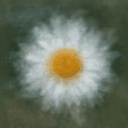

In [134]:
gif = Image.open('./outputs/128-daisy-16-latent-300k-steps.gif')
gif